LSTM Layer를 활용하여 주식 예측해보기 <br>
데이터셋 조건 : 1조, 거래일 10일, next_change : 0.02 <br>
train : 2018-01-01~2020-12-31, val : 2021-01-01 ~ 2021-06-30<br>
Final earning rate : -13.34 %<br>
#################################### <br>
 <br>
LSTM의 경우 모델이 예측한 값이 똑같은 수치로 나타났으며 더미모델과 성능이 비슷하게 나타났다.<br>
모델이 학습을 제대로 되지 않는다고 판단하여 모델 후보로 선택하지 않았다.<br>

In [1]:
import os
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import pickle
import tensorflow as tf
import numpy as np
import pandas as pd

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 2GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)
  
    
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)

print(c)

tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


# 데이터셋 불러오기

In [3]:
def load_file(TYPE,trading, days,target):
    with open('../data/{}_{}_{}_{}.pickle'.format(TYPE,trading, days,target), 'rb') as f:
        data = pickle.load(f)
    return data

In [4]:
def load_model(model,trading, days,target):
    with open('../model/{}_{}_{}_{}.pickle'.format(model,trading, days,target), 'rb') as f:
        model = pickle.load(f)
    return model

In [5]:
train = load_file('train',1000000000000,10,0.02)

val = load_file('val',1000000000000,10,0.02)

In [6]:
lst_code2date=[]
trainX=[]
trainY=[]

for line in train:
    code, date, x, y = line[0], line[1], ','.join(map(str,line[2:-1])), line[-1]
    lst_code2date.append([code, date])
    trainX.append([])
    tmpx = list(map(int, x.split(",")))
    for i in range(0,len(tmpx),5):
        trainX[-1].append(tmpx[i:i+5])
    trainY.append(int(y))
trainX=np.array(trainX)
trainY=np.array(trainY)
    

In [7]:
trainX.shape

(350, 10, 5)

In [8]:
lst_code2date_val = []
valX=[]
valY=[]

for line in val:
    code, date, x, y = line[0], line[1], ','.join(map(str,line[2:-1])), line[-1]
    lst_code2date_val.append([code, date])
    valX.append([])
    tmpx = list(map(int, x.split(",")))
    for i in range(0,len(tmpx),5):
        valX[-1].append(tmpx[i:i+5])
    valY.append(int(y))
valX=np.array(valX)
valY=np.array(valY)
    

In [9]:
valX.shape

(187, 10, 5)

##### LSTM 모델을 돌리기 위해서는 3차원적 data가 필요하다.<br>
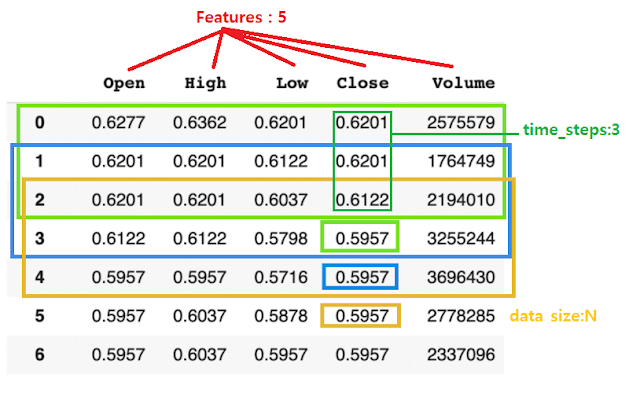
[data_size, time_steps, features]로 구성된다.

우리가 돌리는 데이터는 데이터 행의 개수, 날짜, 특성 개수로 구성된다

In [10]:
from tqdm.notebook import tqdm

from tensorflow import keras

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=(trainX.shape[1],trainX.shape[2])))
model.add(keras.layers.LSTM(128, activation='hard_sigmoid', return_sequences=True))
model.add(keras.layers.LSTM(64, activation='hard_sigmoid', return_sequences=True))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.LSTM(64, activation='hard_sigmoid', return_sequences=True))
model.add(keras.layers.LSTM(32, activation='hard_sigmoid', return_sequences=False))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(1, activation='sigmoid'))
    
model.compile(optimizer=keras.optimizers.Adam(
    learning_rate=keras.optimizers.schedules.ExponentialDecay(0.01,decay_steps=100000,decay_rate=0.96)), 
    loss="binary_crossentropy",
    metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 128)           68608     
                                                                 
 lstm_1 (LSTM)               (None, 10, 64)            49408     
                                                                 
 dropout (Dropout)           (None, 10, 64)            0         
                                                                 
 lstm_2 (LSTM)               (None, 10, 64)            33024     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 3

In [11]:
es = keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=20, verbose=1, mode="auto", restore_best_weights=True)
lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10, verbose=1)


# 최고의 성능 저장
sv = keras.callbacks.ModelCheckpoint(
    "../model/model_keras_lstm.h5", monitor='val_accuracy', verbose=1, save_best_only=True,
    save_weights_only=False, mode='auto', save_freq='epoch',
    options=None
    )

history = model.fit(trainX, trainY, validation_split=0.20, batch_size=128, epochs=50, callbacks=[es, sv], shuffle=True)  

Epoch 1/50
2/3 [===================>..........] - ETA: 0s - loss: 0.7377 - accuracy: 0.5273 
Epoch 1: val_accuracy improved from -inf to 0.71429, saving model to ../model\model_keras_lstm.h5
3/3 [==============================] - 10s 544ms/step - loss: 0.7408 - accuracy: 0.5107 - val_loss: 0.6676 - val_accuracy: 0.7143
Epoch 2/50
2/3 [===================>..........] - ETA: 0s - loss: 0.6943 - accuracy: 0.5391
Epoch 2: val_accuracy did not improve from 0.71429
3/3 [==============================] - 0s 53ms/step - loss: 0.6948 - accuracy: 0.5321 - val_loss: 0.7440 - val_accuracy: 0.2857
Epoch 3/50
3/3 [==============================] - ETA: 0s - loss: 0.7094 - accuracy: 0.4857
Epoch 3: val_accuracy did not improve from 0.71429
3/3 [==============================] - 0s 52ms/step - loss: 0.7094 - accuracy: 0.4857 - val_loss: 0.7377 - val_accuracy: 0.2857
Epoch 4/50
3/3 [==============================] - ETA: 0s - loss: 0.7002 - accuracy: 0.4964
Epoch 4: val_accuracy did not improve from 0.

## 손실 그래프 그리기

In [12]:
import matplotlib.pyplot as plt

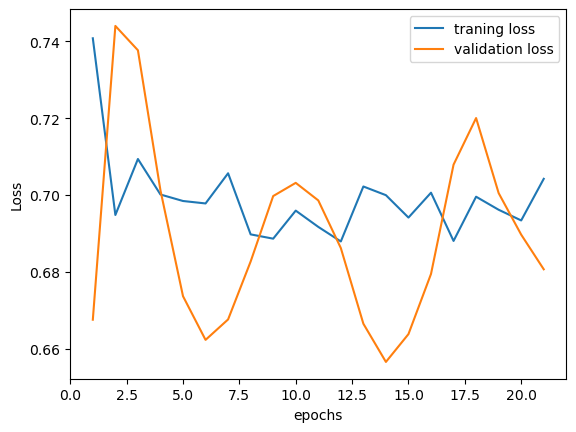

In [13]:
epochs = np.arange(1,len(history.history['loss'])+1)
plt.plot(epochs,history.history['loss'], label = 'traning loss')
plt.plot(epochs, history.history['val_loss'], label = 'validation loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [15]:
# 예측값이 똑같이 나타나 학습이 잘 안된 것으로 판단됨
from tensorflow.keras.models import load_model
saved_model = load_model('../model/model_keras_lstm.h5')
predY = model.predict(valX)
predY

6/6 [==============================] - 1s 7ms/step


array([[0.46775293],
       [0.46775293],
       [0.46775293],
       [0.46775293],
       [0.46775293],
       [0.46775293],
       [0.46775293],
       [0.46775293],
       [0.46775293],
       [0.46775293],
       [0.46775293],
       [0.46775293],
       [0.46775293],
       [0.46775293],
       [0.46775293],
       [0.46775293],
       [0.46775293],
       [0.46775293],
       [0.46775293],
       [0.46775293],
       [0.46775293],
       [0.46775293],
       [0.46775293],
       [0.46775293],
       [0.46775293],
       [0.46775293],
       [0.46775293],
       [0.46775293],
       [0.46775293],
       [0.46775293],
       [0.46775293],
       [0.46775293],
       [0.46775293],
       [0.46775293],
       [0.46775293],
       [0.46775293],
       [0.46775293],
       [0.46775293],
       [0.46775293],
       [0.46775293],
       [0.46775293],
       [0.46775293],
       [0.46775293],
       [0.46775293],
       [0.46775293],
       [0.46775293],
       [0.46775293],
       [0.467

In [17]:
# 수익률 일지
lst_output = []

for (code,date),y in zip(lst_code2date_val, predY):
    if y >= 0.7:
        lst_output.append([code, date, 'buy','r50'])
        lst_output.append([code, date+"n", 'sell', 'all'])
    elif y >= 0.5:
        lst_output.append([code, date, 'buy', 'r30'])
        lst_output.append([code, date+"n", 'sell', 'all'])
    elif y >= 0.3:
        lst_output.append([code, date, 'buy', 'r10'])
        lst_output.append([code, date+"n", 'sell', 'all'])

In [18]:
lst_output[:10]

[['048410', '20210223', 'buy', 'r10'],
 ['048410', '20210223n', 'sell', 'all'],
 ['048410', '20210226', 'buy', 'r10'],
 ['048410', '20210226n', 'sell', 'all'],
 ['024810', '20210209', 'buy', 'r10'],
 ['024810', '20210209n', 'sell', 'all'],
 ['024810', '20210215', 'buy', 'r10'],
 ['024810', '20210215n', 'sell', 'all'],
 ['024810', '20210217', 'buy', 'r10'],
 ['024810', '20210217n', 'sell', 'all']]

In [19]:
lst_output.sort(key = lambda x: x[1]) # date 기준으로 주문 요청 결과 정렬

OF = open('../data/order_request_LSTM.txt','w')
for row in lst_output:
    OF.write('\t'.join(map(str, row)) + '\n')
OF.close()

# 수익률 계산

In [57]:
import pymysql
# database
# con = pymysql.connect()

In [55]:
cursor = con.cursor()

In [21]:
import warnings
warnings.filterwarnings(action='ignore')

In [56]:
start_money = 10000000 # 초기 현금 1천만원
money = start_money
dic_code2num ={}  # 보유 종목


IF = open('../data/order_request_LSTM.txt','r')
for i, line in tqdm(enumerate(IF)): #주문 일지를 한 줄 읽어 옴
    code, date, request, amount = line.strip().split("\t")
    
    ##############################################################################################
    sql_query = '''
                SELECT *
                FROM stock_{}
                WHERE Date
                BETWEEN '2021-01-01' AND '2021-07-01'
                '''.format(code)
    stock = pd.read_sql(sql = sql_query, con = con)
    lst_stock = stock.values.tolist()
    
    for idx, row in enumerate(lst_stock):
        Date = row[0].strftime('%Y%m%d')        
        if date.endswith('n'):
            if date.rstrip('n') == Date:
                sell_close = lst_stock[idx+1][4]
        elif date == Date:
            buy_close = lst_stock[idx][4]

    ##############################################################################################
    
    if request == 'buy': # buy인 경우
        if amount.startswith('r'):
            request_money = money * float(amount.lstrip("r")) / 100
        elif amount == 'all':
            request_money = money
        elif amount.isdigit():
            request_money = int(amount)
        # elif amount == ~~~~~    ##### 기타 필요한 매수 요청 옵션이 있을 시 작성
        else:
            raise Exception('Not permitted option')
        request_money = min(request_money, money)
        buy_num = int(request_money / buy_close)
        money -= buy_num * buy_close  # 현재 금액(money)을 실제 매수액을 뺀 만큼 업데이트
        if code not in dic_code2num:
            dic_code2num[code] = 0
        dic_code2num[code] += buy_num # 보유 종목 데이터에 구매 종목(code)를 매수 개수 만큼 증가
    if request == 'sell': # sell인 경우
        if amount == 'all':
            sell_num = dic_code2num[code]
        # elif amount == ~~~~~    ##### 기타 필요한 매도 요청 옵션이 있을 시 작성
        else:
            raise Exception('Not permitted option')            
        money += sell_num * sell_close
        dic_code2num[code] -= sell_num
        if dic_code2num[code] == 0:
            del dic_code2num[code]
IF.close()            
            
if dic_code2num != {}: # 매매가 종료되었는데 보유 종목이 있으면
    raise Exception('Not empty stock') 

print("Final earning rate : {} %".format(str((money-start_money) / start_money * 100)))


0it [00:00, ?it/s]

Final earning rate : -13.34051 %
